In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)




import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_v3 as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import sys
import matplotlib as mpl

# Clear matplotlib from sys.modules
for module in list(sys.modules.keys()):
    if module.startswith("matplotlib"):
        del sys.modules[module]

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
%config InlineBackend.figure_format = 'retina'
obj = lib.Fisher(fmin = 20, fmax = 2000, n_freq = 4000.)

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [37]:
full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))



data_150914 = np.array(data[1])
data_150914[0] = 3
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390/10

idx = '150914'
if idx=='150914':
    data_150914 = np.array(data[1])
    data_150914[0] = 30
    q  = 0.79
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390
    dat = jnp.array(data_150914)
elif idx=='170817':
    data_150914 = np.array(data[1])
    data_150914[0] = 3
    q  = 0.79
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390/10
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))


epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = 0.
x['s1_x'] = 0.

prec_pe = True
if prec_pe:
    i = None
else:
    i = -2
hgr = obj.get_h_gr(x)
dhgr = obj.get_dh_gr(x)
paramgr = obj.paramdiffgr.copy()[:i]
paramgr_latex = obj.paramdiffgr_latex.copy()[:i]
freqs = obj.freqs.copy()
dets = ["H1", "L1", "V1"]

In [ ]:


from scipy.sparse.linalg import eigsh
r = np.loadtxt("data/cache_delta_psi_3rd.txt")
f_n_orig = np.loadtxt("data/cache_freq_3rd.txt")
fend = f_n_orig[-1]


μ = np.mean(r, axis=0)
σ = np.var(r, axis=0)**(1/2)
R = r - μ
temp = np.einsum('ij,ik->jk', R, R)  # this computes the outer product of ΔΨ(f)*ΔΨ(f') as 2d array and sums it.
cov = temp/len(r[:,0]) # the two point function is the divided by the number of averages.

nλ = 1
λ, v  = eigsh(cov, nλ)
v = np.sign(v[-1,:])* v


In [169]:

def get_dpsi_nvnl(freqs, p):
    Mc = p["M_c"]
    eta = p["eta"]
    dPsi = np.sqrt(λ) * v[:,0]
    dPsi = dPsi- dPsi[-1]

    M = pycbc.conversions.mtotal_from_mchirp_eta(Mc,eta)*Ms
    
    # intp = interp.interp1d(f_n_orig, dPsi, kind='linear', fill_value = (0, dPsi[-1]), bounds_error=False)
    # dPsi = intp(freqs*M)
    dPsi = np.interp(freqs*M, f_n_orig, dPsi, left = 0, right = dPsi[-1])
    return dPsi

get_dpsi_nvnl(freqs, x)

def make_Dh_nvnl_norm(x, snr=1):
    norm = get_dpsi_nvnl(np.array([20]), x) - get_dpsi_nvnl(np.array([6000]), x)
    dphik_guess = 1/norm
    dpsi = dphik_guess* get_dpsi_nvnl(freqs, x)
    h = obj.get_h_gr(x)
    Dh={}
    for d in dets:
        Dh[d] = 1j*dpsi*h[d]
    norm = np.sum([lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets])**(1/2)
    for d in dets:
        Dh[d] = Dh[d]/norm
    return Dh

def compute_Dh_nvnl_perp(dh, x, param, cov):
    Dh = make_Dh_nvnl_norm(x)
    bias_ip = obj.compute_biasip_raw(dh, Dh, x, param)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()

    for p in filter(log_flag.__getitem__, param):
        i = idx_par[p]
        dx_bias[i] *= x[p]
        dx_stat[i] *= x[p]

    dhpara, dhperp = {}, {}
    for d in dets:
        dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in paramgr), jnp.zeros_like(freqs))
        dhperp[d] = Dh[d] - dhpara[d]
    
    if True:
        dperpnorm = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
        dperpnorm = np.sum(dperpnorm)**(1/2)

        for d in dets:
            dhperp[d] = dhperp[d] / dperpnorm
            Dh[d] = Dh[d] / dperpnorm
    return dhperp, Dh



In [180]:
np.sum([lib.innprod(dhperp_nvnl[d], dhperp_nvnl[d], obj.psdO3, obj.freqs) for d in dets])**(1/2)

np.complex128(1+0j)

In [170]:
def make_Dh_ppe(kinj, dphik, x, norm_dh = False):
    Dh = {}
    dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    for d in dets:
        Dh[d] = 1j * dpsi_inj * hgr[d] 
    if norm_dh:
        normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets]
        norm = np.sum(normarr)**(1/2)
        dpsi_inj = dpsi_inj/norm
        for d in dets:
            Dh[d] = Dh[d]/norm
    return Dh

def make_Dh_ppe_norm(kinj, x, snr=1):
    norm = lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
    dphik_guess = 1/norm
    Dh = make_Dh_ppe(kinj, dphik_guess, x, norm_dh = True)
    for d in dets:
        Dh[d] = Dh[d]/snr
    return Dh

def compute_Dh_ppek_perp(k, dh, x, param, cov):
    Dh = make_Dh_ppe_norm(k, x)
    if k==5:
        for d in dets:
            Dh[d] = Dh[d]*0
    bias_ip = obj.compute_biasip_raw(dh, Dh, x, param)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()

    for p in filter(log_flag.__getitem__, param):
        i = idx_par[p]
        dx_bias[i] *= x[p]
        dx_stat[i] *= x[p]

    dhpara, dhperp = {}, {}
    for d in dets:
        dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in paramgr), jnp.zeros_like(freqs))
        dhperp[d] = Dh[d] - dhpara[d]
    
    if k!=5:
        dperpnorm = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
        dperpnorm = np.sum(dperpnorm)**(1/2)

        for d in dets:
            dhperp[d] = dhperp[d] / dperpnorm
            Dh[d] = Dh[d] / dperpnorm
    return dhperp, Dh



dh = obj.get_dh_gr(x)
fi = obj.compute_fisher_raw(dhgr, x, paramgr)
# kk = np.array(list(obj.k2str.keys()))
cov = jnp.linalg.inv(fi)
res = {}
resDh = {}
kk = np.array(list(obj.k2str.keys()))
for k in kk:
    dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, x, paramgr, cov)
    res[obj.k2str[k]] = dhperp
    resDh[obj.k2str[k]] = Dh
# res = compute_Dh_ppek_perp(kk[0], dhgr, x, paramgr, cov)
dhperp_nvnl, Dh_nvnl = compute_Dh_nvnl_perp(dhgr, x, paramgr, cov)

In [171]:
def compute_H_svd(all_dets=True,perp=True):
    rows = []
    for key in obj.str2k:
        if perp:
            detectors = res[key]
        else:
            detectors = resDh[key]
        if all_dets:
            concatenated = np.concatenate([weight*detectors["H1"], weight*detectors["L1"], weight*detectors["V1"]])
        else:
            concatenated = np.concatenate([weight*detectors["H1"]])
        rows.append(concatenated)
    return rows

df = np.diff(obj.freqs)
delta_f = np.empty_like(obj.freqs, dtype=float)
delta_f[1:-1] = (df[:-1] + df[1:]) / 2.0
delta_f[0] = df[0]
delta_f[-1] = df[-1]
weight = np.sqrt(4*delta_f/obj.psdO3)

Hperp = compute_H_svd()
Hperpsingle = compute_H_svd(all_dets=False)
HDh = compute_H_svd(perp=False)


U, s, Vh = np.linalg.svd(Hperp, full_matrices=False)

# prints cov
# ii = 0
# for k in obj.k2str:
#     U, n2, Vh = np.linalg.svd(Hperp[ii:ii+1], full_matrices=False)
#     U, n1, Vh = np.linalg.svd(HDh[ii:ii+1], full_matrices=False)
#     print(n1[0])
#     print(f" {obj.k2str[k]} Dh: {np.real(n1[0]):.2e}, Dhperp: {np.real(n2[0]):.2e}")
#     ii += 1

In [172]:
normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets]
norm = np.sum(normarr)**(1/2)

In [173]:
# obj.k2str[2]
resDh[obj.k2str[2]]["H1"]

Array([6.13580041e-24-6.94100896e-23j,
       1.25620057e-23-6.83391879e-23j,
       1.88283979e-23-6.66808058e-23j, ...,
       0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j], dtype=complex128)

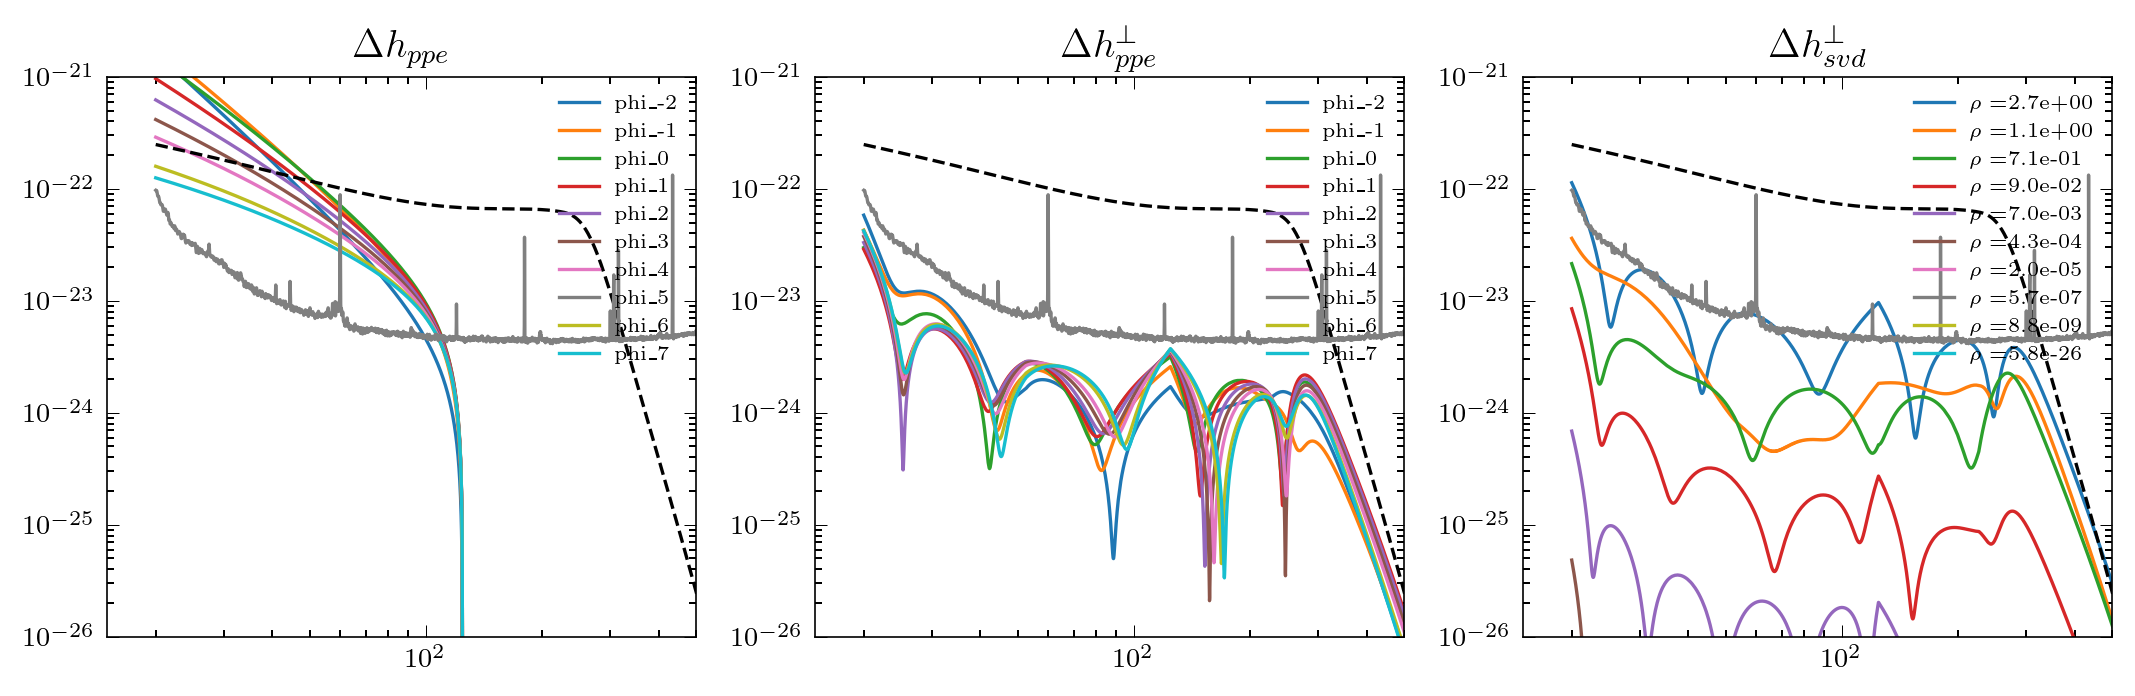

In [174]:
normsvd = np.zeros(s.shape[0])
for j in range(s.shape[0]):
    normarr = np.zeros(3)
    for i in range(3):
        v = s[j]*Vh[j,i*4000:(i+1)*4000]/weight
        normarr[i] = np.real(lib.innprod(v, v, obj.psdO3, obj.freqs))
    normsvd[j] = np.sum(normarr)**(1/2)
    # print(np.sum(normarr)**(1/2))


fig, axs = plt.subplots(1, 3, figsize=(9, 3))

norm = 2*np.sqrt(obj.freqs)
for k in kk:
    axs[0].loglog(obj.freqs, norm*np.abs(resDh[obj.k2str[k]]["H1"]), label=obj.k2str[k])
axs[0].set_title(r"$\Delta h_{ppe}$")

for k in kk:
    axs[1].loglog(obj.freqs, norm*np.abs(res[obj.k2str[k]]["H1"]), label=obj.k2str[k])
axs[1].set_title(r"$\Delta h_{ppe}^\perp$")

for i in range(10):
    axs[2].loglog(obj.freqs, norm*np.abs(s[i] * Vh[i, :4000] / weight), label=rf"$\rho=${normsvd[i]:0.1e}")
axs[2].set_title(r"$\Delta h_{svd}^\perp$")

for i in range(3):
    axs[i].set_xlim(15, 500)
    axs[i].set_ylim(bottom=1e-26,top=1e-21)
    axs[i].legend(loc=1)
    axs[i].loglog(obj.freqs, norm*np.abs(obj.get_h_gr(x)["H1"]), ls="--", c="k")
    axs[i].loglog(obj.freqs, obj.psdO3**(1/2), c="grey")

plt.tight_layout()
plt.show()


In [175]:
rf"$\Delta \Psi_{{SVD {i+1:d} }}$"

'$\\Delta \\Psi_{SVD 3 }$'

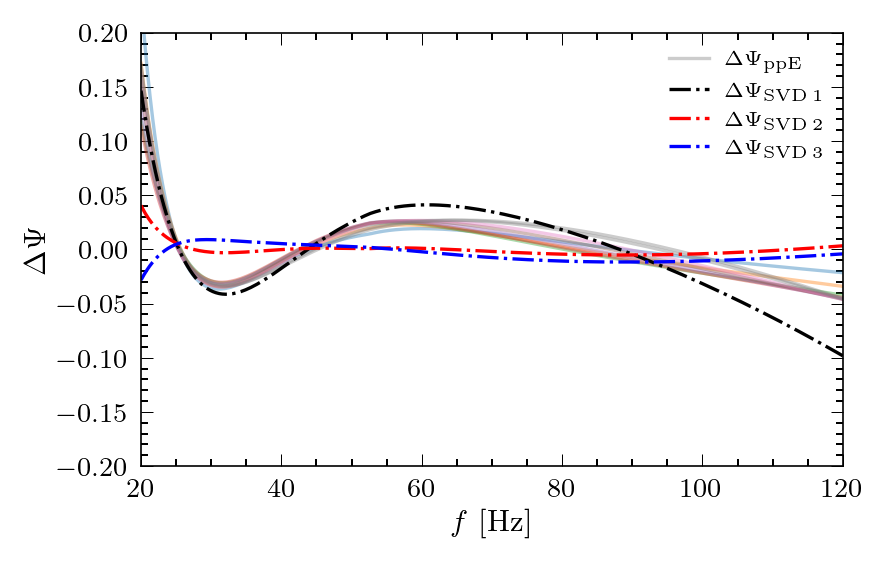

In [ ]:
kkplt = [-2,-1,0,1, 2,3,4,6, 7]

for k in kkplt:
    # line, = plt.plot(obj.freqs,np.real(resDh[obj.k2str[k]]["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ {k:d} }}$")
    if k!=7:
        plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4)
    else:
        plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j), alpha=0.4, c = "gray", label=r"$\Delta \Psi_\mathrm{ppE }$")

cc = ["k","r","b"]
for i in range(3):
    
    vals = norm/27*s[i] * Vh[i, :4000] / weight / hgr["H1"]/1j
    ang = -np.unwrap(np.real(vals))
    # vals = norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j
    # ang2 =  -np.real(norm/27*s[i] * Vh[i, :4000] / weight/ hgr["H1"]/1j)
    plt.plot(obj.freqs,ang, label=rf"$\Delta \Psi_{{\mathrm{{SVD}}\, {i+1:d} }}$",ls = "-.",c=cc[i])

plt.xlim(20, 120)
plt.ylim(-0.2,0.2)
plt.legend(loc=1)

plt.xlabel(r"$f$ [Hz]") 
plt.ylabel(r"$\Delta \Psi$") 
# plt.savefig("svd-example.pdf", bbox_inches='tight', pad_inches=0) 

plt.show()

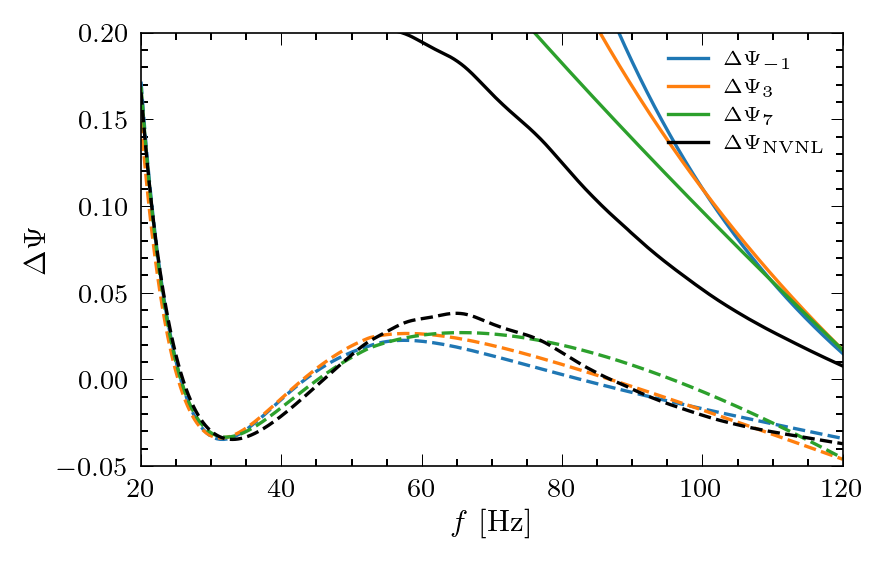

In [194]:
kkplt = [-1, 3, 7]

for k in kkplt:
    line, = plt.plot(obj.freqs,np.real(resDh[obj.k2str[k]]["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ {k:d} }}$")
    plt.plot(obj.freqs, np.real(res[obj.k2str[k]]["H1"] / hgr["H1"]/1j) , color = line.get_color(), ls = "--")

line, = plt.plot(obj.freqs,np.real(Dh_nvnl["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ \mathrm{{NVNL}} }}$", c = "k")
plt.plot(obj.freqs, np.real(dhperp_nvnl["H1"] / hgr["H1"]/1j) , color = line.get_color(), ls = "--")

plt.xlim(20, 120)
plt.ylim(-0.5,3)
plt.ylim(-0.05,0.2)
plt.legend(loc=1)

plt.xlabel(r"$f$ [Hz]") 
# plt.ylim(-3/10,3)
plt.ylabel(r"$\Delta \Psi$") 
# plt.savefig(datestr+"-psi-example.pdf", bbox_inches='tight', pad_inches=0) 

# plt.ylim(-0.1/10,0.1)
# plt.savefig("psiperp-example2.pdf", bbox_inches='tight', pad_inches=0) 

plt.show()

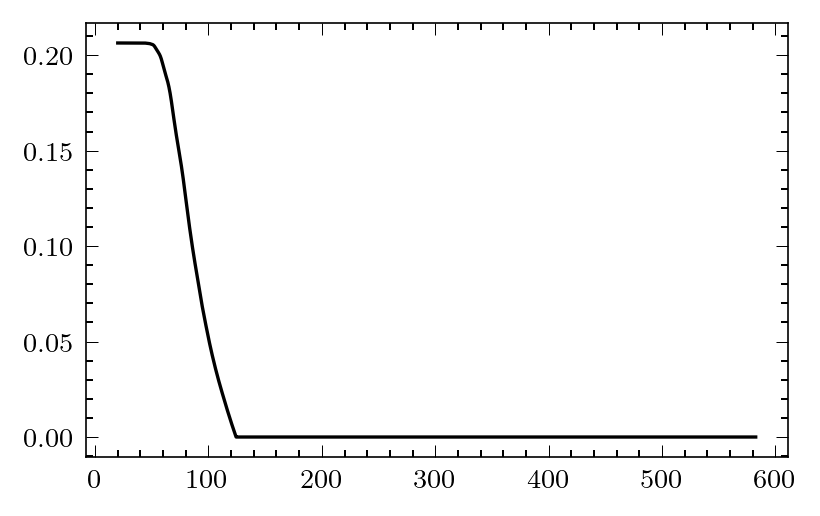

In [178]:
plt.plot(obj.freqs,np.real(Dh_nvnl["H1"] / hgr["H1"]/1j), label=rf"$\Delta \Psi_{{ \mathrm{{NVNL}} }}$", c = "k")

In [6]:
rows = []
for key in obj.str2k:
    detectors = res[key]
    df = np.diff(obj.freqs)
    delta_f = np.empty_like(obj.freqs, dtype=float)
    delta_f[1:-1] = (df[:-1] + df[1:]) / 2.0
    delta_f[0] = df[0] / 2.0
    delta_f[-1] = df[-1] / 2.0
    weight = np.sqrt(2*delta_f/obj.psdO3)
    concatenated = np.concatenate([weight*detectors["H1"], weight*detectors["L1"], weight*detectors["V1"]])
    rows.append(concatenated)

result_array = np.vstack(rows)
U, s, Vh = np.linalg.svd(result_array, full_matrices=False)
sf = s
s

array([5.87290604e-01, 1.24045729e-01, 2.58568545e-02,
       1.92814718e-02, 2.70735867e-03, 2.30886798e-04,
       1.54001929e-05, 6.06092816e-07, 1.56851738e-08,
       2.53816397e-10])

In [ ]:
dhperp, Dh = compute_Dh_ppek_perp(1, dhgr, x, paramgr, cov)

for k in obj.k2str:
    dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, x, paramgr, cov)
    res[obj.k2str[k]] = dhperp
    resDh[obj.k2str[k]] = Dh
    normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets]
    n1 = np.sum(normarr)**(1/2)

    normarr = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
    n2 = np.sum(normarr)**(1/2)
    print(f" {obj.k2str[k]} Dh: {np.real(n1):.2e}, Dhperp: {np.real(n2):.2e}")


 phi_-2 Dh: 1.00e+00, Dhperp: 2.67e-02
 phi_-1 Dh: 1.00e+00, Dhperp: 2.05e-02
 phi_0 Dh: 1.00e+00, Dhperp: 2.28e-02
 phi_1 Dh: 1.00e+00, Dhperp: 3.05e-02
 phi_2 Dh: 1.00e+00, Dhperp: 4.09e-02
 phi_3 Dh: 1.00e+00, Dhperp: 5.33e-02
 phi_4 Dh: 1.00e+00, Dhperp: 6.70e-02
 phi_5 Dh: 1.00e+00, Dhperp: 8.31e-01
 phi_6 Dh: 1.00e+00, Dhperp: 9.59e-02
 phi_7 Dh: 1.00e+00, Dhperp: 1.10e-01


In [ ]:
# Old code -----

dh = obj.get_dh_gr(x)
fi = obj.compute_fisher_raw(dhgr, x, paramgr)
cov = jnp.linalg.inv(fi)
dx_stat = np.diagonal(np.array(cov ))**(1/2)
idx_par = obj.idx_par.copy()
log_flag = obj.log_flag.copy()

Dh = {}
dx_bias = {}
k = 1
Dh = make_Dh_ppe_norm(k, x)
bias_ip = obj.compute_biasip_raw(dhgr, Dh, x, paramgr)
dx_bias = np.array(cov @ bias_ip)

for p in filter(log_flag.__getitem__, paramgr):
    i = idx_par[p]
    dx_bias[i] *= x[p]
    dx_stat[i] *= x[p]

dhpara, dhperp = {}, {}
for d in dets:
    dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in paramgr), jnp.zeros_like(freqs))
    dhperp[d] = Dh[d] - dhpara[d]

dpsi_perp = np.array((dhperp["H1"])/1j/hgr["H1"])


def compute_netsnr(data, psd, freqs, detectors):
    total_innprod = sum(lib.innprod(data[d], data[d], psd, freqs) for d in detectors)
    return np.real(np.sqrt(total_innprod))

snr        = compute_netsnr(hgr, obj.psdO3, obj.freqs, dets)
snr_dh     = compute_netsnr(Dh, obj.psdO3, obj.freqs, dets)
snr_dhperp = compute_netsnr(dhperp, obj.psdO3, obj.freqs, dets)
snr_dhpara = compute_netsnr(dhpara, obj.psdO3, obj.freqs, dets)

res = {'freqs' : freqs, 'dpsi_perp' : dpsi_perp, 'dh' : Dh["H1"], 'h' : hgr["H1"], 'dh_perp' : dhperp["H1"], 'dx_bias' : dx_bias, 'dx_stat' : dx_stat, 'snr':snr, 'snr_dh':snr_dh, 'snr_dhperp':snr_dhperp, 'snr_dhpara':snr_dhpara}

array([-2, -1,  0,  1,  2,  3,  4,  5,  6,  7])